In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch

from pybefit.agents import RLSocInf, HGFSocInf, SGFSocInf
from pybefit.inference import Horseshoe

%matplotlib inline
sns.set(style = 'white', color_codes = True)

In [59]:
blocks = 1  # number of experimental blocks

responses = torch.from_numpy(np.load('follow.npy')).float().unsqueeze(0)
nsub = responses.shape[-1]//2  # number of subjects
trials = responses.shape[-2]  # number of trials

mask = (~torch.isnan(responses)).float()
responses = torch.nan_to_num(responses).long()

offers = torch.from_numpy(np.load('offers.npy')).reshape(trials, -1, 1).repeat(1, 1, nsub)\
            .reshape(trials, -1).unsqueeze(0)

reliability = torch.from_numpy(2. * np.load('advice_reliability.npy') - 1.).float()
reliability = reliability.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)

stimulus = {
    'offers': offers, 
    'outcomes': torch.stack([reliability, torch.ones_like(reliability)], -1),
    'mask': mask
}

evidence = torch.zeros(3, 2 * nsub)
num_samples = 1000

In [3]:
# RL agent
rl_agent = RLSocInf(runs=2*nsub, trials=trials)
rl_agent.set_parameters()

rl_infer = Horseshoe(rl_agent, stimulus, responses, mask=mask.byte())
rl_infer.infer_posterior(iter_steps=5000)

rl_par_names = ['alpha', 'zeta', 'beta', 'bias']
rl_df = rl_infer.formated_results(rl_par_names)
sample_rl = rl_infer.sample_posterior(rl_par_names, num_samples=num_samples)
evidence[0] = rl_infer.get_log_evidence_per_subject()

Mean ELBO 7396.33: 100%|█████████████████████| 5000/5000 [19:12<00:00,  4.34it/s]


In [5]:
#HGF agent
hgf_agent = HGFSocInf(runs=2*nsub, trials=trials)
hgf_agent.set_parameters()

hgf_infer = Horseshoe(hgf_agent, stimulus, responses, mask=mask.byte())
hgf_infer.infer_posterior(iter_steps=5000)

hgf_par_names = ['mu0_2', 'eta', 'zeta', 'beta', 'bias']
hgf_df = hgf_infer.formated_results(hgf_par_names)
sample_hgf = hgf_infer.sample_posterior(hgf_par_names, num_samples=num_samples)
evidence[1] = hgf_infer.get_log_evidence_per_subject()

Mean ELBO 7409.85: 100%|█████████████████████| 5000/5000 [39:09<00:00,  2.13it/s]


In [6]:
# SGF agent
sgf_agent = SGFSocInf(runs=2*nsub, trials=trials)
sgf_agent.set_parameters()

sgf_infer = Horseshoe(sgf_agent, stimulus, responses, mask=mask.byte())
sgf_infer.infer_posterior(iter_steps=5000)

sgf_par_names = ['rho1', 'h', 'zeta', 'beta', 'bias']
sgf_df = sgf_infer.formated_results(sgf_par_names)
sample_sgf = sgf_infer.sample_posterior(sgf_par_names, num_samples=num_samples)
evidence[2] = sgf_infer.get_log_evidence_per_subject()

Mean ELBO 7430.44: 100%|█████████████████████| 5000/5000 [41:35<00:00,  2.00it/s]


In [7]:
# the model with lovest cumulative log evidence (summed over participants) is the RL model
evidence.sum(-1)

tensor([-7385.1626, -7395.3740, -7416.2598])

In [8]:
def errorplot(*args, **kwargs):
    subjects = args[0]
    values = args[1]
    percentiles = args[2]

    
    low_perc = values[percentiles == '5th']
    up_perc = values[percentiles == '95th']
    
    x = subjects[percentiles == 'median']
    y = values[percentiles == 'median']
    
    kwargs['yerr'] = [y.values-low_perc.values, up_perc.values-y.values]
    kwargs['linestyle'] = ''
    kwargs['marker'] = 'o'
    
    plt.errorbar(x.values, 
                 y.values, 
                 **kwargs)

def format_num(value):
    if value == 1 or value == 10:
        return 'adult'
    else:
        return 'teen'

def append_condition(df, number_pars):
    values = io.loadmat('Conditions.mat')['subjectSubMapping']
    
    labels = ['advisor', 'participant', 'session', 'subject ID']
    
    vals = [
        np.array([format_num(v) for v in values[:, -1]]),
        np.array([format_num(v) for v in values[:, -2]]),
        values[:, -3],
        values[:, -4]
    ]
    
    for lbl, val in zip(labels, vals):
        expanded_val = np.tile(np.tile(val, (3, 1)).reshape(-1), (number_pars,))
        df[lbl] = expanded_val
    
    locs = df.advisor == 'adult' 
    df.loc[locs, 'subject ID'] += .2
    df.loc[~locs, 'subject ID'] -= .2
    
append_condition(rl_df, rl_agent.npar)
append_condition(hgf_df, hgf_agent.npar)
append_condition(sgf_df, sgf_agent.npar)

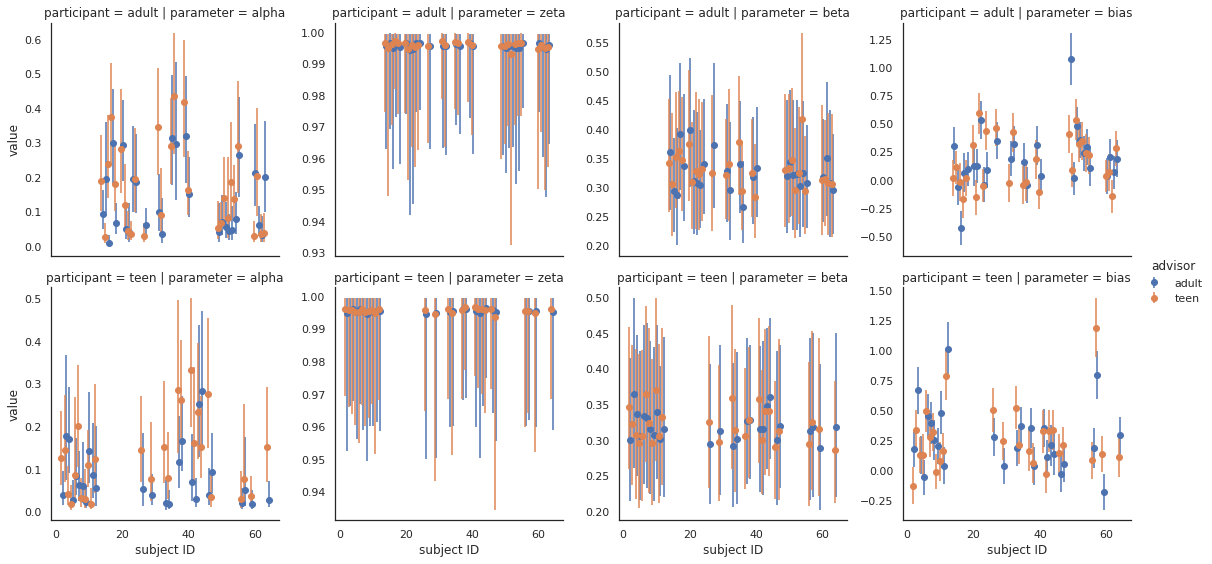

In [9]:
g = sns.FacetGrid(rl_df, col="parameter", row = 'participant', hue = 'advisor', height=4, sharey=False);
g = (g.map(errorplot, 'subject ID', 'value', 'variables')).add_legend();

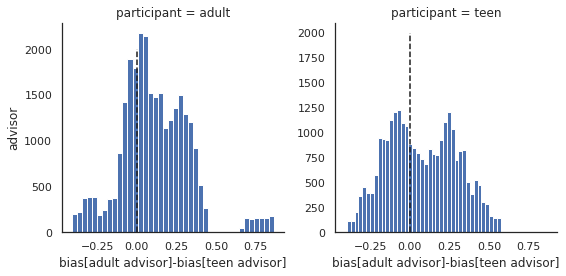

In [10]:
# Here we plot distribution over posterior estimates of bias differences between adult and teen advisors.
# A distribution with more weight above zero, suggest higher response bias for adult advisors on avarage.
# Note that the repsone bias denotes a prior preference of accepting advice.

subset1 = rl_df.loc[rl_df['parameter'] == 'bias']

def histogram(*args, **kwargs):
    sid = args[0]
    adv = args[1]
    var = args[2]
    val = args[3]
    
    adult = adv == 'adult'
    teen = adv == 'teen'
    
    up = var == '95th'
    med = var == 'median'
    low = var == '5th'
    
    sig = (val[up].values - val[low].values)/4
    sort1 = np.argsort(sid[adult & med].values)
    sort2 = np.argsort(sid[teen & med].values)
    
    diff = val[adult & med].values[sort1] - val[teen & med].values[sort2]
    sig1 = (val[adult & up].values - val[adult & low].values)/4
    sig2 = (val[teen & up].values - val[teen & low].values)/4
    sig = sig1[sort1] + sig2[sort2]
    
    sample = diff + sig*np.random.rand(1000, 1)
    
    plt.hist(sample.flatten(), bins = 40, **kwargs)
    plt.vlines(0, 0, 2000, color='k', linestyle='--')
    
g = sns.FacetGrid(subset1, col="participant", height=4, sharey=False);
g = (g.map(histogram, 'subject ID', 'advisor', 'variables', 'value'));
g.axes[0, 0].set_xlabel('bias[adult advisor]-bias[teen advisor]');
g.axes[0, 1].set_xlabel('bias[adult advisor]-bias[teen advisor]');

In [11]:
# Clustering - we will split participants (both teens and adults) in three groups based on their preference
# to accept advice from adults. If posterior sample of bias difference is grater than zero with probability
# .75 or larger, we will classify this participant as having preference for 'adult' advices. If 
# the probability is .25 or smaler, we will classify this participant as having preferences for 'teen' 
# advices. All other cases we will classify as having 'neutral' preferences. 


# Number of samples per component
n_samples = 1000

# Generate random sample, two components
def sample_bias(df, participant, n_samples):
    df_part = df.loc[df['participant'] == participant]
    adult = df_part.advisor == 'adult'
    teen = df_part.advisor == 'teen'
    
    up = df_part.variables == '95th'
    med = df_part.variables == 'median'
    low = df_part.variables == '5th'
    
    vals = df_part.value
    
    sid = df_part['subject ID']
    sort1 = np.argsort(sid[adult & med].values)
    sort2 = np.argsort(sid[teen & med].values)
    
    diff = vals[adult & med].values[sort1] - vals[teen & med].values[sort2]
    sig1 = (vals[adult & up].values - vals[adult & low].values)/4
    sig2 = (vals[teen & up].values - vals[teen & low].values)/4
    sig = sig1[sort1] + sig2[sort2]

    return diff + sig*np.random.rand(n_samples, 1)

X_adult = sample_bias(subset1, 'adult', n_samples)
X_teen = sample_bias(subset1, 'teen', n_samples) 


adult_bias = np.sum(X_adult > 0, axis = 0)/n_samples
print((adult_bias > .75).sum()/len(adult_bias))
print((adult_bias < .25).sum()/len(adult_bias))

teen_bias = np.sum(X_teen > 0, axis = 0)/n_samples
print((teen_bias > .75).sum()/len(teen_bias))
print((teen_bias < .25).sum()/len(teen_bias))

df1 = subset1.pivot(index='subjects', columns='variables', values='value')
df1['std'] = (df1['95th'] - df1['5th'])/4
df1['mean'] = df1['median']
df1 = df1.loc[:, ['mean', 'std']]

df2 = subset1.reset_index(drop=True).loc[:109, 
                                         ['subjects', 'advisor', 'participant', 'subject ID', 'session']]
df2 = df2.set_index('subjects')

result = pd.concat([df1, df2], axis=1, sort=False)
result.index.names = ['index']
result = result.sort_values('subject ID')
result = result.reset_index(drop=True)

result['preference'] = np.NaN

adult_bias = np.tile(adult_bias.reshape(1, -1), (2,1)).T.reshape(-1)
result.loc[result.participant == 'adult', 'preference'] = \
    (adult_bias > .75).astype(np.int32) - (adult_bias < .25).astype(np.int32)

teen_bias = np.tile(teen_bias.reshape(1, -1), (2,1)).T.reshape(-1)

result.loc[result.participant == 'teen', 'preference'] = \
    (teen_bias > .75).astype(np.int32) - (teen_bias < .25).astype(np.int32)

# result.to_csv('bias_estimates.csv')

0.5714285714285714
0.14285714285714285
0.5555555555555556
0.37037037037037035


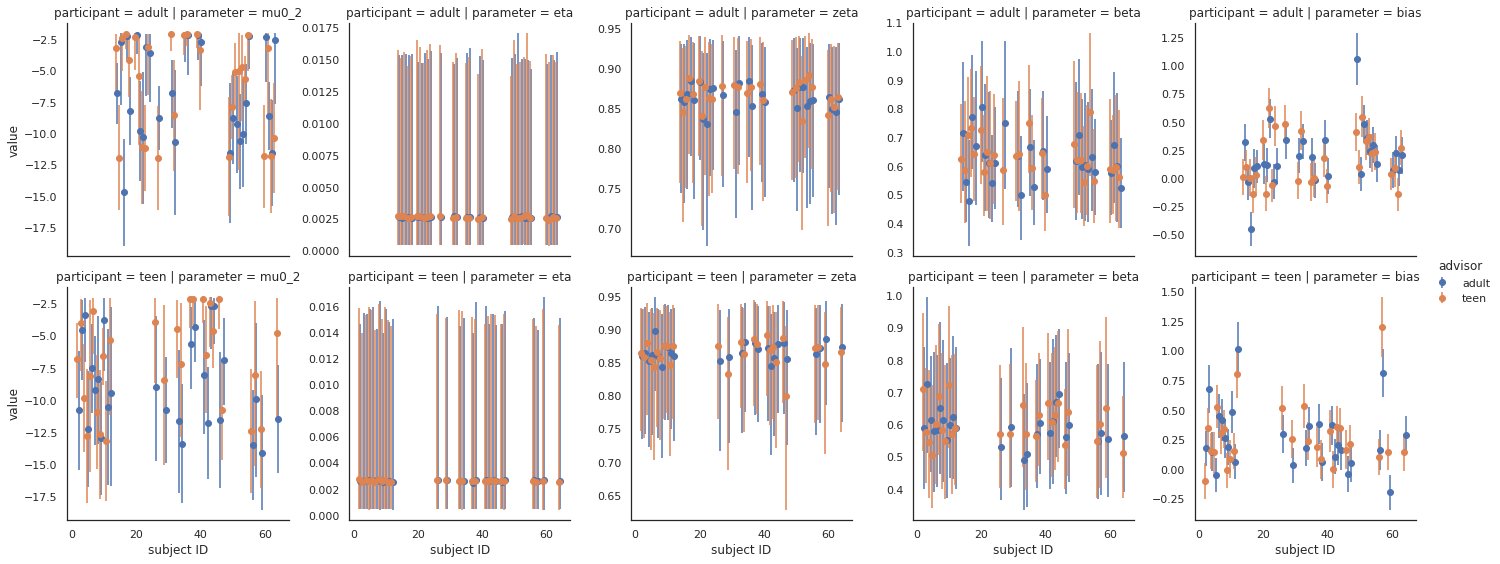

In [12]:
g = sns.FacetGrid(hgf_df, col="parameter", row = 'participant', hue = 'advisor', height=4, sharey=False);
g = (g.map(errorplot, 'subject ID', 'value', 'variables')).add_legend();

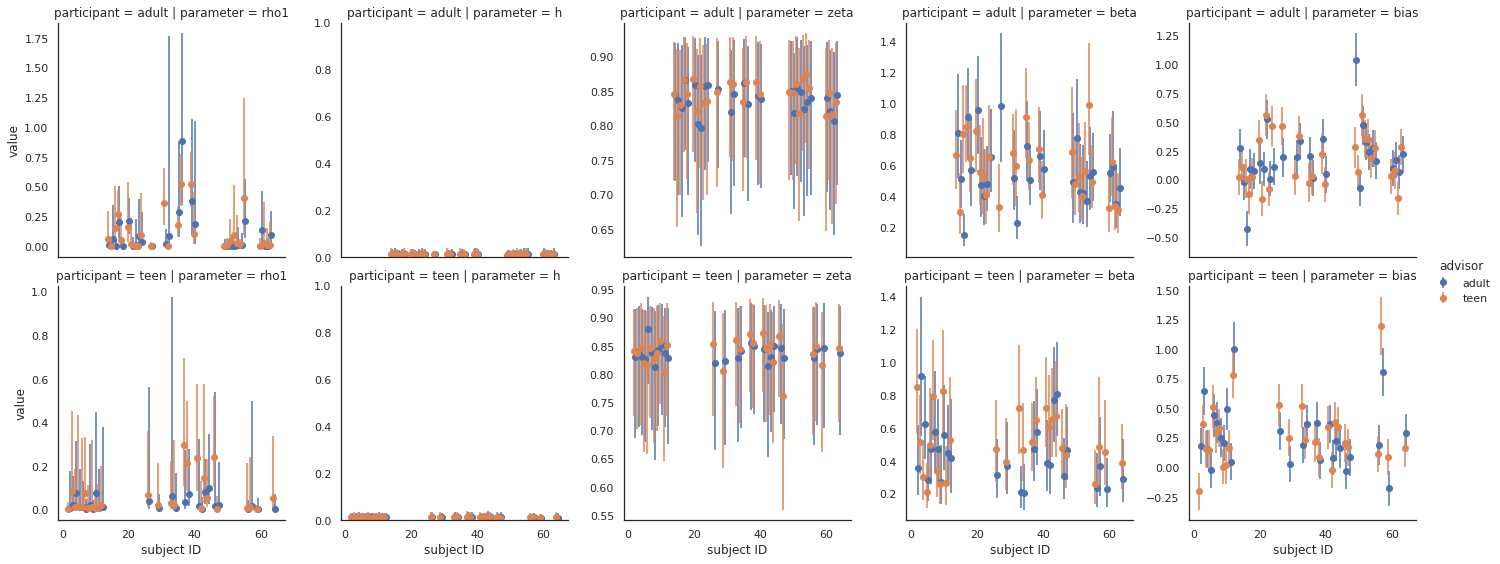

In [13]:
g = sns.FacetGrid(sgf_df, col="parameter", row = 'participant', hue = 'advisor', height=4, sharey=False);
g = (g.map(errorplot, 'subject ID', 'value', 'variables')).add_legend();
g.axes[0, 1].set_ylim([0, 1]);
g.axes[1, 1].set_ylim([0, 1]);

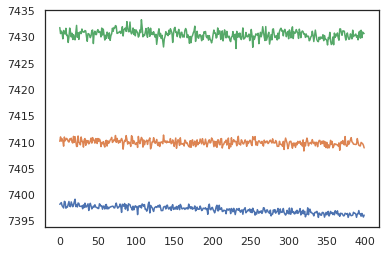

In [14]:
plt.plot(rl_infer.loss[-400:]);
plt.plot(hgf_infer.loss[-400:]);
plt.plot(sgf_infer.loss[-400:]);

In [78]:
from pybefit.tasks import SocialInfluence
from pybefit.simulate import Simulator

# format sample into parameter values
pars_rl = torch.from_numpy(sample_rl[0].values[:, :-1]).float()
pars_hgf = torch.from_numpy(sample_hgf[0].values[:, :-1]).float()
pars_sgf = torch.from_numpy(sample_sgf[0].values[:, :-1]).float()

# load stimuli (trial offers, advices, and reliability of advices)
outcomes = torch.from_numpy(np.load('advice_outcome.npy')).float()
outcomes = outcomes.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)

reliability = torch.from_numpy(np.load('advice_reliability.npy')).float()
reliability = reliability.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)
offers = torch.from_numpy(np.load('offers.npy')).reshape(trials, -1, 1).repeat(1, 1, nsub)\
            .reshape(trials, -1).unsqueeze(0)

runs = len(pars_rl)
num_samples = runs//(2 * nsub)
stimuli = {'offers': offers.repeat(1, 1, num_samples), 
           'reliability': reliability.repeat(1, 1, num_samples)}

tasks = [SocialInfluence(stimuli, nsub=nsub), SocialInfluence(stimuli, nsub=nsub), SocialInfluence(stimuli, nsub=nsub)]

In [79]:
# RL agent
rl_agent = RLSocInf(runs=runs, trials=trials)
rl_agent.set_parameters(pars_rl)

# HGF agent
hgf_agent = HGFSocInf(runs=runs, trials=trials)
hgf_agent.set_parameters(pars_hgf)

# SGF agent
sgf_agent = SGFSocInf(runs=runs, trials=trials)
sgf_agent.set_parameters(pars_sgf)

sim = Simulator(tasks, [rl_agent, hgf_agent, sgf_agent], trials=trials)
sim.simulate_experiment();

# readout trajectories 
rl_V = torch.stack(rl_agent.values[:-1]).reshape(trials, -1, 2*nsub)

hgf_mu = torch.stack(hgf_agent.mu[:-1]).reshape(trials, -1, 2*nsub, 2)
hgf_pi =torch.stack(hgf_agent.pi[:-1]).reshape(trials, -1, 2*nsub, 2)

sgf_mu = torch.stack(sgf_agent.mu)[:-1].reshape(trials, -1, 2*nsub)
sgf_sig = torch.stack(sgf_agent.sig)[:-1].reshape(trials, -1, 2*nsub)
sgf_theta = torch.stack(sgf_agent.theta)[:-1].reshape(trials, -1, 2*nsub)

In [80]:
values = io.loadmat('Conditions.mat')['subjectSubMapping']

labels = ['advisor', 'participant', 'session', 'subject ID']

vals = [
    values[:, -1],
    values[:, -2],
    values[:, -3],
    values[:, -4]
]

sess1 = torch.from_numpy(vals[-2]) == 1  # first session
adults = torch.from_numpy(vals[1]) == 10  # adult 
advisor = torch.from_numpy(vals[0]) == 1  # adult advisors
seq =  torch.ones(2*nsub, dtype=torch.bool)  # first sequence type
seq[nsub:] = 0

def plot_trajectories(trajectories, sequence, adults, advisors, ylabel):
    titles = ['adult advisor', 'teen advisor']
    adv = [advisors, ~advisors]
    for i in range(2):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
        loc1 = adv[i]*sequence*adults
        axes[0].plot(trajectories[..., loc1].median(dim=1)[0].numpy(), c='b', alpha=.1);
        axes[0].plot(trajectories[..., loc1].reshape(trials, -1).median(dim=-1)[0].numpy(), c='b', lw=3, label='adults');

        loc2 = adv[i]*sequence*(~adults)
        axes[0].plot(trajectories[..., loc2].median(dim=1)[0].numpy(), c='r', alpha=.1);
        axes[0].plot(trajectories[..., loc2].reshape(trials, -1).median(dim=-1)[0].numpy(), c='r', lw=3, label='teens');

        loc3 = adv[i]*(~sequence)*adults
        axes[1].plot(trajectories[..., loc3].median(dim=1)[0].numpy(), c='b', alpha=.1);
        axes[1].plot(trajectories[..., loc3].reshape(trials, -1).median(dim=-1)[0].numpy(), c='b', lw=3, label='adults');

        loc4 = adv[i]*(~sequence)*(~adults)
        axes[1].plot(trajectories[..., (~seq)*(~adults)*advisor].median(dim=1)[0].numpy(), c='r', alpha=.1);
        axes[1].plot(trajectories[..., (~seq)*(~adults)*advisor].reshape(trials, -1).median(dim=-1)[0].numpy(), c='r', lw=3, label='teens');

        axes[0].legend(title='participant')
        axes[0].set_ylabel(ylabel);
        axes[0].set_xlim([0, 120])
        axes[0].set_title('sequence 1');
        axes[1].set_xlim([0, 120])
        axes[1].set_title('sequence 2');

        fig.suptitle(titles[i], fontsize = 20);

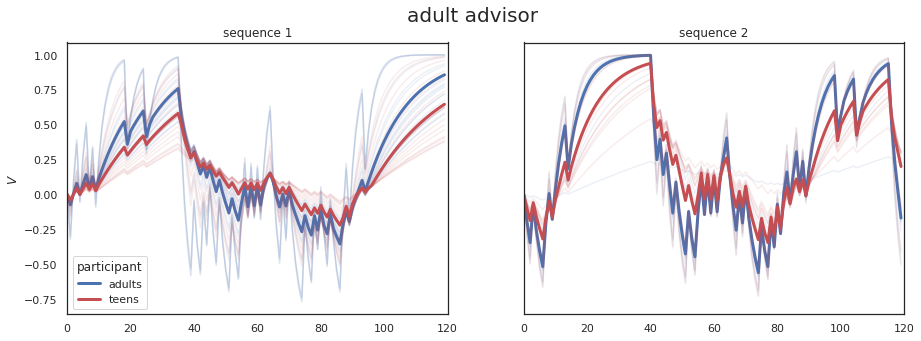

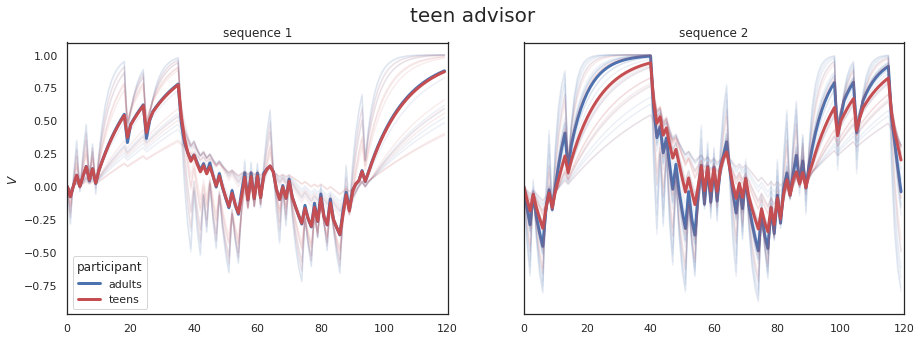

In [81]:
# plot median expectation of the RL model between sequence, advisor's age, and participant's age
plot_trajectories(rl_V, seq, adults, advisor, r'$V$')

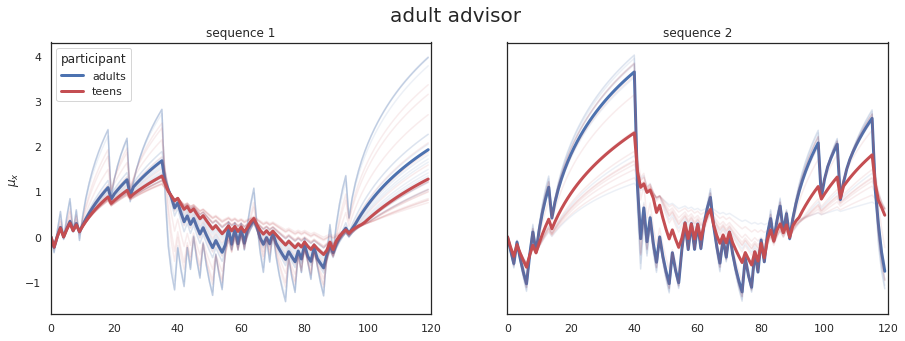

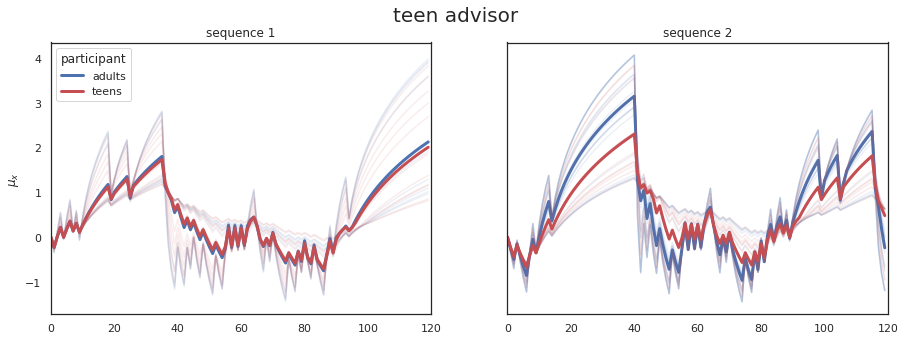

In [82]:
# plot median expectation of the HGF model between sequence, advisor's age, and participant's age
plot_trajectories(hgf_mu[..., 0], seq, adults, advisor, r'$\mu_x$')

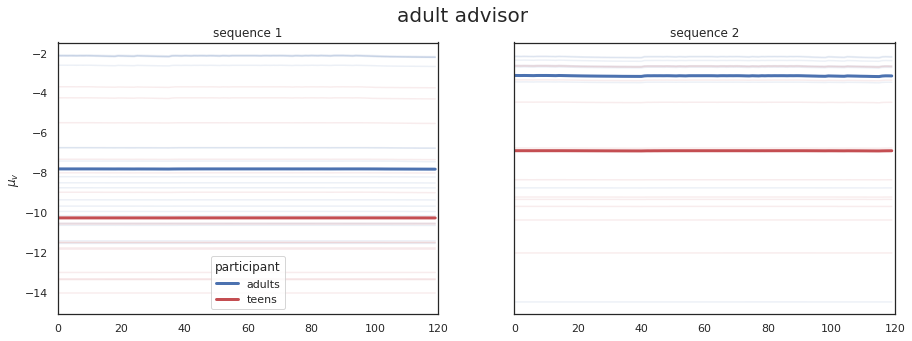

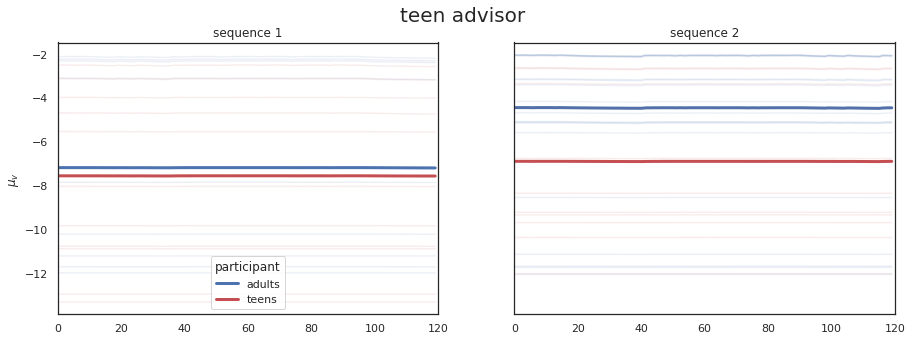

In [83]:
# plot median volatility between sequence, advisor's age, and participant's age
plot_trajectories(hgf_mu[..., 1], seq, adults, advisor, r'$\mu_v$')

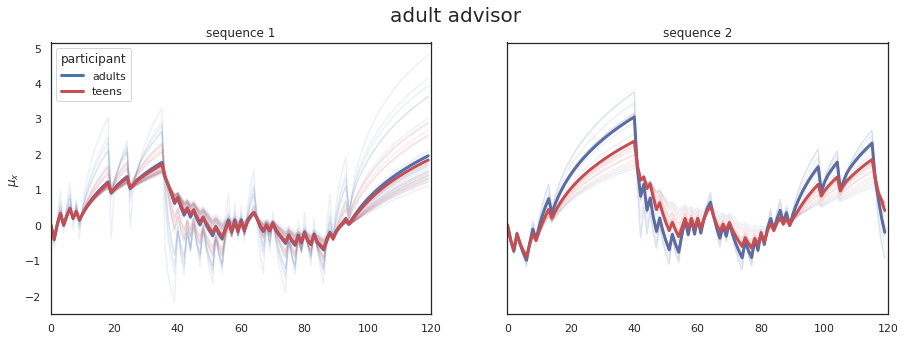

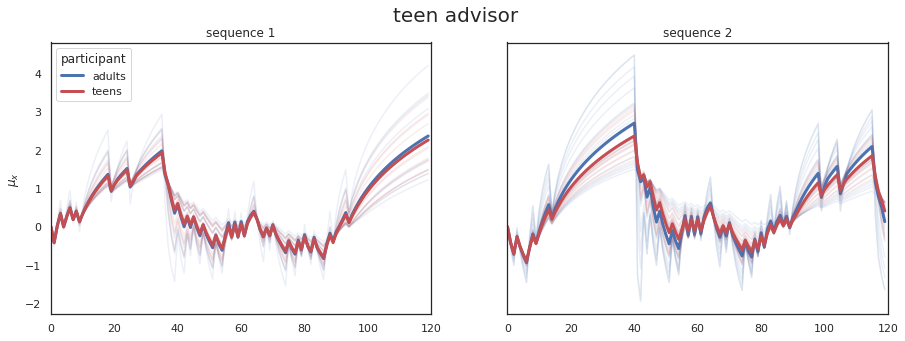

In [84]:
# plot median expectation between sequence, advisor's age, and participant's age
plot_trajectories(sgf_mu, seq, adults, advisor, r'$\mu_x$')

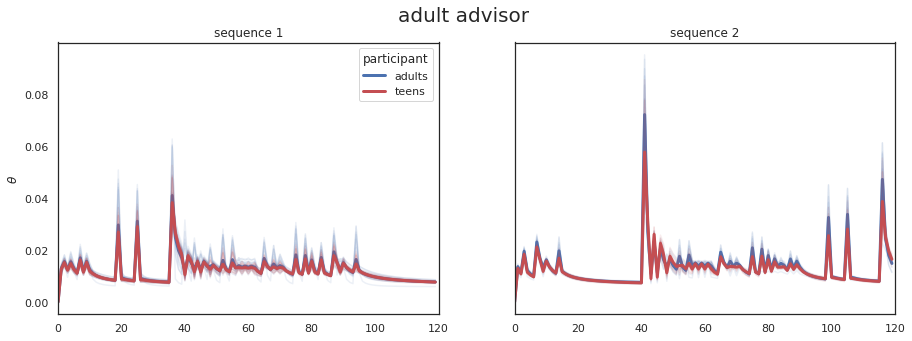

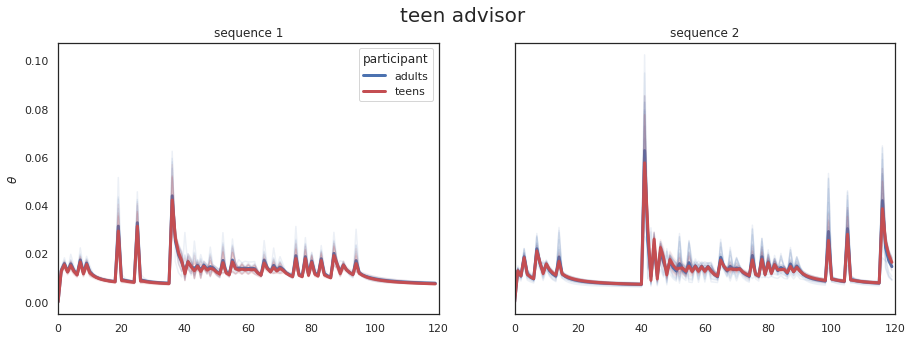

In [85]:
# plot median expectation between sequence, advisor's age, and participant's age
plot_trajectories(sgf_theta, seq, adults, advisor, r'$\theta$')